# Elasticsearch Data Analytics

This notebook provides sample code to fetch Elasticsearch Data into and analyze it.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.antaresnet.com/wp-content/uploads/2018/07/Elasticsearch-Logo-Color-V.png")

## Loading modules and connect to the Elastic Stack

In [2]:
import sys
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import pytz
from datetime import datetime, timedelta
from dateutil import tz

import matplotlib.pyplot as plt
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (18,10)

In [3]:
# connect to our cluster
from elasticsearch import Elasticsearch
es = Elasticsearch([{'host': 'elasticsearch', 'port': 9200}])
print('Last run: {} UTC, status: {} %'.format(
    datetime.utcnow(),
    es.cluster.health()['active_shards_percent_as_number']))
es.info()

Last run: 2019-12-20 08:12:58.766840 UTC, status: 7.0604683677036 %


{'name': 'c185f3ed577c',
 'cluster_name': 'il.es.cluster',
 'cluster_uuid': 'sBgbgyRXTvKta2cEJCczKQ',
 'version': {'number': '6.2.2',
  'build_hash': '10b1edd',
  'build_date': '2018-02-16T19:01:30.685723Z',
  'build_snapshot': False,
  'lucene_version': '7.2.1',
  'minimum_wire_compatibility_version': '5.6.0',
  'minimum_index_compatibility_version': '5.0.0'},
 'tagline': 'You Know, for Search'}

Display our indices and document types saved in elasticsearch.

Update the elasticsearch package.

In [5]:
!sudo pip install "elasticsearch>=7.0.0,<8.0.0"

## Defining useful functions

In [6]:
# %load scroller.py
def scroller(index, quantity, timerange=timedelta(days=0), startdt="", enddt=""):
    print("Starting to scroll", end='')
    # Retrieve the datetimes, note that timerange has a higher priority
    if timerange.total_seconds() > 0:
        now = datetime.utcnow().replace(tzinfo=pytz.UTC)
        startdt = (now - timerange).isoformat()
        enddt = now.isoformat()
    
    # search the first page and write the result to data
    response = es.search(
        index=index,
        body={
                      "query": {
                        "bool": {
                          "must": [
                            {"range" : {
                                "phenomenonTime" : {
                                    #"gte": "2018-02-20T09:08:34.230693+00:00", 
                                    "gte": startdt,
                                    "lte": enddt, 
                                    "time_zone": "+01:00"
                                }
                            }},
                            {
                              "match_phrase": {
                                "Datastream.name.keyword": quantity
                              }
                            }
                          ]
                        }
                      }
                    },
        scroll='10m'
    )
    data = [[row["_source"]["phenomenonTime"], row["_source"]["result"]] for row in response['hits']['hits']]

    # Append new pages until there aren't any left
    while len(response['hits']['hits']):
        print(".", end='')
        # process results
        # print([item["_id"] for item in response["hits"]["hits"]])
        response = es.scroll(scroll_id=response['_scroll_id'], scroll='10m')
        data +=  [[row["_source"]["phenomenonTime"], row["_source"]["result"]] for row in response['hits']['hits']]
    
    # Convert data to a DataFrame and return it
    df = pd.DataFrame(data, columns=["phenomenonTime", quantity])
    # df.index = pd.to_datetime(df["phenomenonTime"].map(lambda t: t.split(".")[0]), utc=True)
    df.index = pd.to_datetime(df["phenomenonTime"].map(lambda t: roundto(t, 1)), utc=True)
    df = df.drop(["phenomenonTime"], axis=1)
    print("\nFetched {} tuples.".format(df.shape[0]))
    return df

def roundto(string, n):
    base = string.split(".")[0]
    if n > 0:
        base += "." + string.split(".")[1][:n]
    return base


# Gather data from Elasticsearch

It is supposed that in the Elasticsearch instance, there is data with the Datastream.name "at.srfg.iot-iot4cps-wp5.CarFleet1.car_1.Air Temperature" within the index name "at.srfg.iot-iot4cps-wp5.infraprov.internal-*"

In [7]:
# Get data for an index and a quantity between two static timestamps
startdt="2019-08-07T08:58:34+00:00"
enddt="2019-08-07T11:58:34+00:00"
df = scroller("at.srfg.iot-iot4cps-wp5.infraprov.internal-*",
              "at.srfg.iot-iot4cps-wp5.CarFleet1.car_1.Air Temperature",
              startdt=startdt, enddt=enddt)
df.head()

Starting to scroll
Fetched 0 tuples.


,at.srfg.iot-iot4cps-wp5.CarFleet1.car_1.Air Temperature
phenomenonTime,


In [12]:
# Get data for an index and a quantity of the latest timerange
df = scroller("at.srfg.iot-iot4cps-wp5.infraprov.internal-*",
              "at.srfg.iot-iot4cps-wp5.CarFleet1.car_1.Air Temperature",
              timerange=timedelta(days=10))
df.head()

Starting to scroll
Fetched 0 tuples.


,at.srfg.iot-iot4cps-wp5.CarFleet1.car_1.Air Temperature
phenomenonTime,


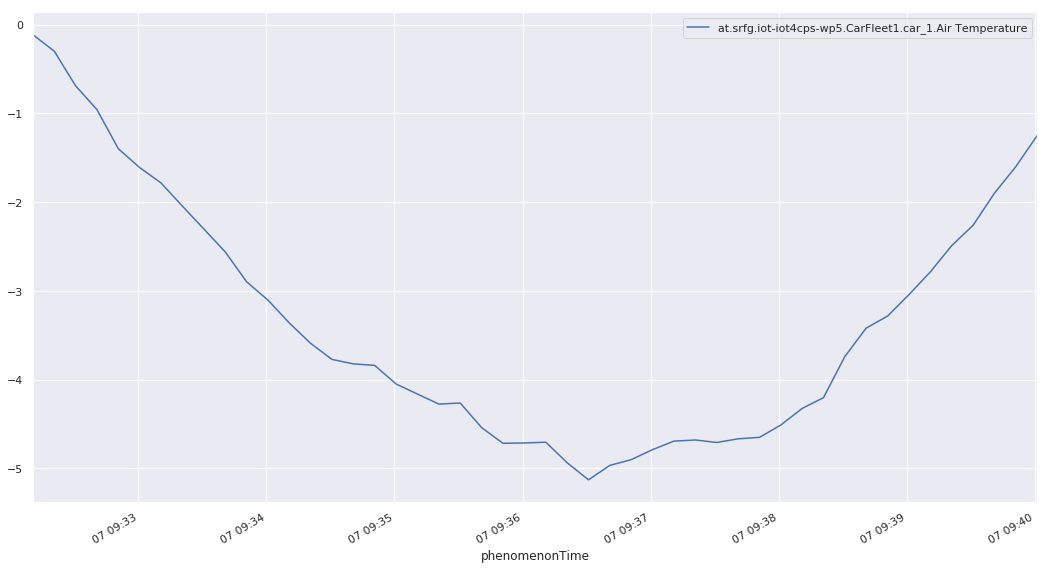

In [51]:
# Plot the extracted data using pandas and seaborn
df.plot()
plt.show()

In [52]:
# Get multiple quantities and (outer) join them to a single DataFrame.
# There can be a lot of missing values
used_quantities = ["at.srfg.iot-iot4cps-wp5.CarFleet1.car_1.Air Temperature", 
                   "at.srfg.iot-iot4cps-wp5.CarFleet2.car_2.Air Temperature"]

In [53]:
df = scroller("at.srfg.iot-iot4cps-wp5.infraprov.internal-*",
              used_quantities[0],
              timerange=timedelta(days=10))
for q in used_quantities[1:]:
    print(q)
    df = df.join(scroller("at.srfg.iot-iot4cps-wp5.infraprov.internal-*", q,
                          timerange=timedelta(days=10)),
                 how="outer")

Starting to scroll.....
Fetched 48 tuples.
at.srfg.iot-iot4cps-wp5.CarFleet2.car_2.Air Temperature
Starting to scroll
Fetched 0 tuples.


In [54]:
df.head()

,at.srfg.iot-iot4cps-wp5.CarFleet1.car_1.Air Temperature,at.srfg.iot-iot4cps-wp5.CarFleet2.car_2.Air Temperature
phenomenonTime,,
2019-08-07 09:32:50.600000+00:00,-1.396915,NaN
2019-08-07 09:33:40.700000+00:00,-2.559881,NaN
2019-08-07 09:34:10.700000+00:00,-3.360251,NaN
2019-08-07 09:32:10.600000+00:00,-0.112741,NaN
2019-08-07 09:32:40.600000+00:00,-0.956904,NaN


## Store and retrieve the DataFrame in a csv

In [55]:
df.to_csv("elasticsearchdata.csv")

In [56]:
df = pd.read_csv("elasticsearchdata.csv", parse_dates=True, index_col='phenomenonTime')
df.tail()

,at.srfg.iot-iot4cps-wp5.CarFleet1.car_1.Air Temperature,at.srfg.iot-iot4cps-wp5.CarFleet2.car_2.Air Temperature
phenomenonTime,,
2019-08-07 09:39:01.100000+00:00,-3.039692,NaN
2019-08-07 09:39:51.100000+00:00,-1.599475,NaN
2019-08-07 09:39:21.100000+00:00,-2.488179,NaN
2019-08-07 09:39:31.100000+00:00,-2.259640,NaN
2019-08-07 09:40:01.200000+00:00,-1.246612,NaN


# Pre-processing

## Reduce size and interpolate

In [57]:
df = pd.read_csv("elasticsearchdata.csv", parse_dates=True, index_col='phenomenonTime')

In [58]:
df.index.names = ["time"]

In [59]:
col_mapping = {"at.srfg.iot-iot4cps-wp5.CarFleet1.car_1.Air Temperature": "car1_temp", 
                        "at.srfg.iot-iot4cps-wp5.CarFleet2.car_2.Air Temperature": "car2_temp"}
df = df.rename(index=str, 
               columns=col_mapping)

In [60]:
df.head()

,car1_temp,car2_temp
time,,
2019-08-07 09:32:50.600000+00:00,-1.396915,NaN
2019-08-07 09:33:40.700000+00:00,-2.559881,NaN
2019-08-07 09:34:10.700000+00:00,-3.360251,NaN
2019-08-07 09:32:10.600000+00:00,-0.112741,NaN
2019-08-07 09:32:40.600000+00:00,-0.956904,NaN


In [61]:
# Interpolate forwards and backwaonly up to 
df = df.interpolate(method ='linear', limit_direction ='both', limit=10)
df = df.interpolate(method ='linear', limit_direction ='both', limit=10)

In [62]:
# Keep only the rows with at least 2 non-NA values.
df = df.dropna(thresh=2)

In [63]:
# make Timestamp unique
df = df.reset_index()
df = df.groupby("time").agg({q: "mean" for q in col_mapping.values()})

In [64]:
# Interpolate again to close gaps, use the smalles value 
df = df.interpolate(method ='zero', limit_direction ='forward')
df = df.interpolate(method ='zero', limit_direction ='forward')

In [65]:
df.index.min()

nan

In [66]:
df.shape

(0, 2)

In [67]:
df.isna().sum()

car1_temp    0
car2_temp    0
dtype: int64

In [68]:
df.describe()

,car1_temp,car2_temp
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [69]:
# Keep only rows with all filled rows
df = df.dropna()

In [70]:
df.to_csv("elasticsearchdata.csv")

# Basic Data Analysis

In [71]:
df = pd.read_csv("elasticsearchdata.csv", parse_dates=True, index_col='time')
df.tail()

,car1_temp,car2_temp
time,,


In [72]:
# df.hist()
plt.show()

In [73]:
# pd.plotting.scatter_matrix(df, alpha=0.2)
plt.show()

In [74]:
# corr = df.corr() 
cm = sns.light_palette("orange", as_cmap=True) 
cm = sns.diverging_palette(220, 20, sep=20, as_cmap=True) 
# corr.style.background_gradient(cmap=cm).set_precision(2)

# Feature Engineering

This task is very domain-specific and must be done by an expert.

# Data Analytics

In [77]:
from IPython.html.widgets import *
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"] = (18,10)
sns.set(style="darkgrid")

def plot3D(pitch, yaw):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot = ax.scatter(df['car1_temp'], df['car1_temp'], df['car2_temp'], c=df["car1_temp"], s=60)
    fig.colorbar(plot)
    ax.view_init(pitch, yaw)
    ax.legend(['Vibration for each 3D position'])
    ax.set_xlabel("x-Position")
    ax.set_ylabel("y-Position")
    ax.set_zlabel("z-Position")
interact(plot3D, pitch=(0,90,1), yaw=(0,90,1))
plt.show()

interactive(children=(IntSlider(value=45, description='pitch', max=90), IntSlider(value=45, description='yaw',…

In [78]:
# df[col_mapping.values()].hist()
plt.show()

In [79]:
# pd.plotting.scatter_matrix(df[["vib", "distance", "projection", "v-radial", "v-tang"]], alpha=0.5)
plt.show()

In [80]:
# bins = np.linspace(0, df['v-radial'].max(), 10)
# df["binned-v-radial"] = pd.cut(df['v-radial'], bins)
# df.groupby("binned-v-radial").agg({"vib": {"min", "median", "mean", "max", "count"}})

In [81]:
# corr = df[df.columns.sort_values()].corr()[["vib", "vib-x", "vib-y"]]
# cm = sns.light_palette("orange", as_cmap=True) 
# cm = sns.diverging_palette(220, 20, sep=20, as_cmap=True) 
# corr.style.background_gradient(cmap=cm).set_precision(2)

In [82]:
from IPython.display import Markdown 
Markdown("""
## Inline Description:

It is very nice to describe results using Markdown with dynamic values like: **{pi}**.

""".format(pi=np.pi))


## Inline Description:

It is very nice to describe results using Markdown with dynamic values like: **3.141592653589793**.



# Machine Learning

**Be careful when handling with Artificial Intelligence:**

![Be careful when handling with Artificial Intelligence](https://imgs.xkcd.com/comics/twitter_bot.png)
